# Analysis of Credit Card Fraud Detection dataset

## TODO

* Perform data wrangling more intensive (null validation, remove rows with problems etc).
* Give `Time` variable a better representation.
* Rethink about duplicated rows.
* Refactor all graphics to use _seaborn_ insted of plain _matplotlib_.
* Explore more deeply t-SNE inner working.
* Create Trello board.

## Description

From Kaggle ([link](https://www.kaggle.com/dalpozz/creditcardfraud)):

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Database released under Open Database License, individual contents under Database Contents License

## Analysis

Import packages and modules to be used in analysis.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sc
import pandas as pd
import sklearn as sk
import sklearn.manifold as skm
import matplotlib.pyplot as plt
import seaborn as sns

Load data into Pandas DataFrame with the `pandas.read_csv()` method.

In [2]:
data = pd.read_csv("../data/creditcard.csv")

### Preliminary analysis

Firstly, we must take a look at our dataset. A reasonable first step is to know its size, variables names and types and memory usage. We can do all this with the `dataframe.info()` method.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Here we see that the dataset is composed of 31 variables. There are 28 variables resulting from PCA transformation of the original data (unknown to us due to privacy contraints). The other 3 variables are `Time`, `Amount` and `Class`.

The `Time` variable is the number of seconds elapsed between that transaction and the first transaction of the dataset.  
The `Amount` variable is the amount of money in that transaction.  
The `Class` variable defines if that transaction was a fraud or not: 1 indicates it was a fraud (a positive case); 0 indicates it was a normal transaction (a negative case).  

Now we can explore the first rows (observations) of the data with the `dataframe.head()` method.

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, all variables are numeric. As `V1` to `V28` have no special semantics, we can focus on summarising just `Time` and `Amount` variables. We can do this with the `dataframe.describe()` method.

In [5]:
data.loc[:, ('Time', 'Amount')].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


Although `Time` does not give us much useful information, `Amount` statistics are very informative.

We then subset the dataset into two new datasets. The first one contains only fraud observations. The second one contains normal transactions.

In [6]:
frauds = data.loc[data.Class == 1]
normal = data.loc[data.Class == 0]

### Comparing frauds and normal transactions

Again, the first step with these datases is to explore them using the `dataframe.describe()` method.

In [7]:
print("Number of frauds: {}".format(len(frauds)))
frauds.loc[:, ['Time', 'Amount']].describe()

Number of frauds: 492


,Time,Amount
count,492.000000,492.000000
mean,80746.806911,122.211321
std,47835.365138,256.683288
min,406.000000,0.000000
25%,41241.500000,1.000000
50%,75568.500000,9.250000
75%,128483.000000,105.890000
max,170348.000000,2125.870000


In [8]:
print("Number of normal transactions: {}".format(len(normal)))
normal.loc[:, ['Time', 'Amount']].describe()

Number of normal transactions: 284315


,Time,Amount
count,284315.000000,284315.000000
mean,94838.202258,88.291022
std,47484.015786,250.105092
min,0.000000,0.000000
25%,54230.000000,5.650000
50%,84711.000000,22.000000
75%,139333.000000,77.050000
max,172792.000000,25691.160000


It would be interesting to see the ratio of the amount of money spent between the frauds and normal transactions.

In [9]:
amount_fraud = np.sum(frauds['Amount'])
amount_normal = np.sum(normal['Amount'])
amount_ratio = amount_fraud/amount_normal

print("Fraud amount: $ {:.2f}".format(amount_fraud))
print("Normal transaction amount: $ {:.2f}".format(amount_normal))
print("Amount ratio: {:.5f} or {:.5f}%".format(amount_ratio, 100 * amount_ratio))

Fraud amount: $ 60127.97
Normal transaction amount: $ 25102462.04
Amount ratio: 0.00240 or 0.23953%


As we can see, the amount of money spent in frauds is just a small percentage of that spent in normal transactions. It is good news to financial institutions.

Then we wonder if there are any duplicated (or replicated) observations. For our surprise, there is plenty of duplicated observations. We don't know the reason of this.

In [10]:
# Duplicates.
data[data.duplicated(keep = False)] # 'keep = False' makes all duplicated observations to be included.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
220,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
221,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0


## Visualizations

It is time to get a visual look at this data. We begin this graphical analysis with histograms. They give us distribution information about the data that can help us defining the next steps to take.

### Histograms

The first histograms we will plot are the number of frauds and normal transactions by time.

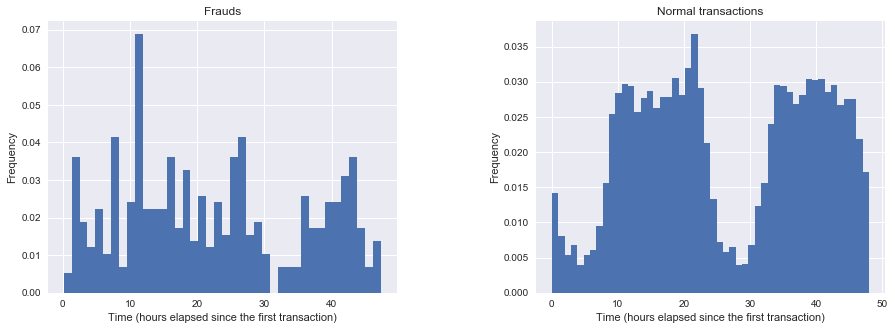

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.subplots_adjust(hspace=1.0, wspace=0.4)

# Frauds.
ax[0].hist(frauds.Time/3600, bins = 40, normed = True);
ax[0].set(xlabel = "Time (hours elapsed since the first transaction)",
          ylabel = "Frequency",
          title = "Frauds");

# Transações normais
ax[1].hist(normal.Time/3600, bins = 50, normed = True);
ax[1].set(xlabel = "Time (hours elapsed since the first transaction)",
          ylabel = "Frequency",
          title = "Normal transactions");

In the frauds case, we don't notice any pattern beyond a peak around 10 hours. In contrast, normal transactions seem to be seasonal. There is a high amount of transactions starting at 10 hours until 20 hours and starting over again around 35 hours and so on. As we don't know the exact real time of the first transaction, we can not say at which time those transactions occur.

We then plot scatterplots of `Amount` by `Time`. The objective is to realize any relationship between these variables. In other words, we want to see the time evolution of the amount of money spent in each case.

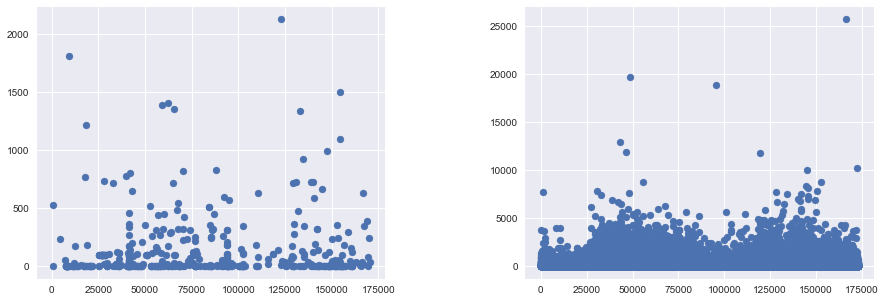

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.subplots_adjust(hspace=1.0, wspace=0.4)

ax[0].scatter(frauds['Time'], frauds['Amount']); # Frauds.
ax[1].scatter(normal['Time'], normal['Amount']); # Normal transactions.

As we can see, there is no visible pattern in either the frauds case or the normal transactions case. Anyway, these two plots confirm that most of transactions are low-value ones. It makes sense in both cases. Fraud transactions are hard to detect as they go small, unnoticed. Normal transactions also tend to be relatively small although they are numerous.

Below we explore their boxplots. We just saw that are many low-value transactions in both cases. Boxplots helps us to visualize their distributions clearer.

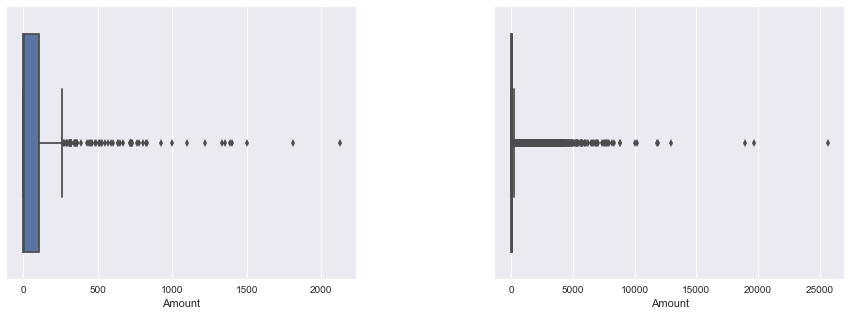

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.subplots_adjust(hspace=1.0, wspace=0.4)

sns.boxplot(frauds['Amount'], ax = ax[0]);
sns.boxplot(normal['Amount'], ax = ax[1]);

It is easy to note that both data are highly positive skewed. There are a lot of points in the right long tail.

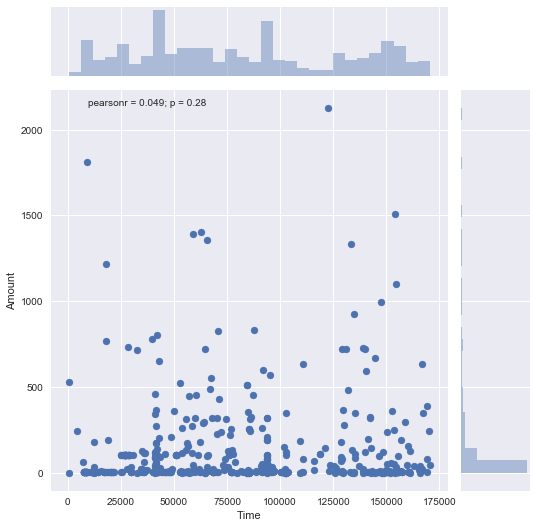

In [14]:
sns.jointplot("Time", "Amount", frauds, size = 7.5, marginal_kws = dict(bins = 30)); # Frauds.

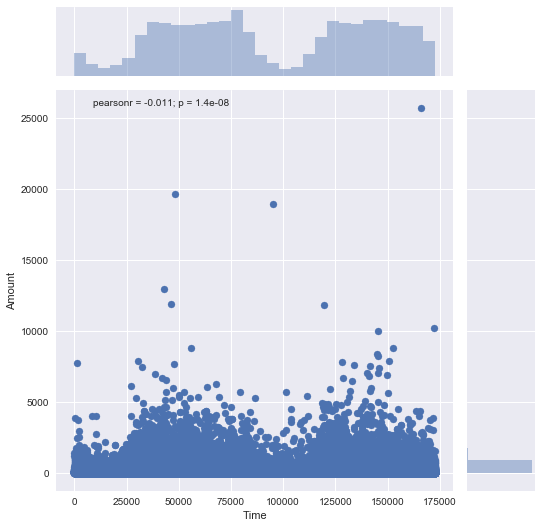

In [15]:
sns.jointplot("Time", "Amount", normal, size = 7.5, marginal_kws = dict(bins = 30)); # Normal transactions.

These two joint plots just summarizes in one single figure what we've already seen. Although it add no news, it is undoubtedly very pretty.

## Dimensionality reduction with t-SNE

Based on kernel [Visualization on a 2D map (with t-SNE)](https://www.kaggle.com/cherzy/d/dalpozz/creditcardfraud/visualization-on-a-2d-map-with-t-sne), we've decided to perform dimensionality reduction with the t-SNE algorithm in order to apply a classification technique.

#### Resample

The complete dataset is too large and the sklearn's implementation of t-SNE does not seem to perform too well in this case. So we resample the data by taking normal transaction and fraud observations in proportion 5/1, excluding `Time` and `Amount` variables. This gives us a more balanced and manageable dataset.

In [16]:
sample_frauds = frauds.iloc[:, 1:-2].sample(frac = 1.00, replace = False)
sample_normal = normal.iloc[:, 1:-2].sample(n = 5*len(sample_frauds), replace = False) # 5/1 without 'Time' and 'Amount'
sample_data = sample_frauds.append(sample_normal)

In [17]:
tsne_model = skm.TSNE(n_components = 2, random_state = 0, angle = 0.3)
tsne_transformed = tsne_model.fit_transform(sample_data);
tsne_transformed = tsne_transformed.T

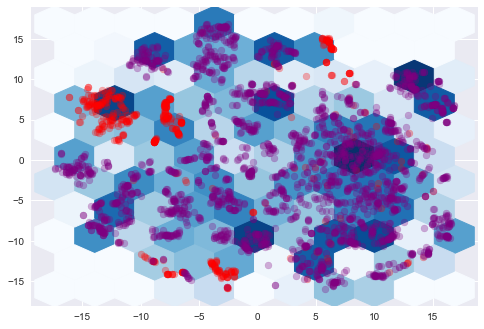

In [18]:
plt.hexbin(tsne_transformed[0], tsne_transformed[1], gridsize = 10, cmap = 'Blues')

plt.scatter(tsne_transformed[0][:len(sample_frauds)],
            tsne_transformed[1][:len(sample_frauds)],
            alpha = 0.3, color = 'Red')

plt.scatter(tsne_transformed[0][len(sample_frauds):],
            tsne_transformed[1][len(sample_frauds):],
            alpha = 0.3, color = 'Purple')

This seems to tell us that it is reasonable to apply a non linear classifier technique to the dataset in order to detect what is fraud and what is not. There are clearly some clusters of frauds (in red) and normal transactions (in purple).

We are still reasoning about the next steps to take from here.